# Modeling the transition between exact coherent states of Plane Couette flow

_(B. Kaszás, M. Cenedese. Adapted from the live script https://github.com/haller-group/SSMLearn/tree/main/examples/couetteflow)_



These computations are described in the manuscript [3]. We take velocity fields generated by Channelflow [4] and build reduced order models which are able to capture the transition between dynamically relevant coherent states, with parametric dependance on the Reynolds number. We note that the results presented in the manuscript were obtained by processing the full velocity fields, which had resolution $(N_x, N_y, N_z) = (32, 35, 32)$.

In this notebook, simply to avoid having to upload large volumes of data, we use a compressed representation of the full flow fields by taking the projection to the first 20 PCA modes. Note that, due to the choice of our coordinates, this compression has no influence on the dynamical modeling. The full data is available from the authors upon request. 
We use data describing the transition between the three coexisting fixed points (or equilibria).  We denote the velocity field by

$$
\mathbf{u}(x,y,z,t) = \begin{pmatrix}u(x,y,z,t) \\
v(x,y,z,t) \\
w(x,y,z,t)
\end{pmatrix}.
$$

The laminar base state at the origin 

$$
\mathbf{u}(x,y,z,t) = \begin{pmatrix}y \\
0 \\
0
\end{pmatrix}
$$
is a stable fixed point in this flow. The lower and upper branch fixed points appear in a saddle-node bifurcation at $\text{Re}=134.50$. The lower branch is an unstable fixed point, while the upper branch is stable. In this notebook, we fix $\text{Re} = 135$, and conclude that a reduced-order model can be obtained by restricting the flow to a two-dimensional spectral submanifold (SSM) [5]. Indeed, there exists a unique, robust smoothest invariant manifold tangent to the least stable subspace of the stable fixed point. We choose to parametrize this manifold using the square root of the energy input rate $J = \sqrt{|I|}$ and that of the energy dissipation rate $K= \sqrt{|D|}$, where $I$ and $D$ are defined as

$$
I =  \frac{1}{2 L_x L_z} \int_0^{L_x} \int_0^{L_z} \left(\left.  \frac{\partial u}{\partial y}\right\vert_{y=1} + \left. \frac{\partial u}{\partial y}\right\vert_{y=-1}\right)\ \text{d}z \ \text{d}x-1, \\
    D = \frac{1}{2L_xL_z}\int_0^{L_x}\int_{-1}^1\int_0^{L_z}|\nabla \times \mathbf{u}|^2\  \text{d}z \ \text{d}y \ \text{d}x-1.
$$

With this definition, the rate of energy input  is equal to zero at the laminar base state. The use the square root  of  as parametrizing coordiates of the SSM is due to its capability to describe the spectral subspace of the SSM, while  suffers of a singularity issue near the laminar base state as pointed out in [3].

__Bibliography__:

[1] J. Page & R. R. Kerswell, Koopman mode expansions between simple invariant solutions, Journal of Fluid Mechanics 879, 1-27 (2019) 

[2] J. F. Gibson, J. Halcrow & P. Cvitanović, Visualizing the geometry of state space in plane Couette flow, Journal of Fluid Mechanics, 611, 107–130, (2008)

[3] B. Kaszás, M. Cenedese & G. Haller, Modeling transitions between exact coherent states in plane Couette flow, submitted, (2022)


[4] J. F. Gibson, Channelflow: A spectral Navier-Stokes simulator in C++, Tech. Rep. (U. New Hampshire, 2014) [Channelflow.org.](https://channelflow.ch)


[5] G. Haller & S. Ponsioen, Exact model reduction by a slow-fast decomposition of nonlinear mechanical systems. Nonlinear Dynamics 90, 617-647, (2017) 


[6] M. Cenedese, J. Axås, B. Bäuerlein, K. Avila & G. Haller, Data-driven modeling and prediction of non-linearizable dynamics via spectral submanifolds Nat. Commun. 13 872.  (2022) 

## Parameter dependent model 

In this notebook, we concentrate on the regime
$$
\text{Re} \in [134.50, 134.53].
$$

Here the connection between the upper branch and the lower branch is one dimensional, that is the underlying Spectral Submanifold is one dimensional. Since the SSM is smooth in the parameters of the dynamical system, we look for a parametrization that is $\text{Re}-$dependent. 

In [1]:
from scipy.io import loadmat
from ssmlearnpy import SSMLearn
from ssmlearnpy.reduced_dynamics.advector import advect
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

mat = loadmat('dataRe134.mat')
n_traj_train = 6
t_train = [mat['aData'][i][0].flatten() for i in range(n_traj_train)]
x_full_train = [mat['aData'][i][1] for i in range(n_traj_train)]
x_reduced_train = [np.sqrt(mat['xData'][i][1]) for i in range(n_traj_train)]
parameters_train = [mat['aData'][i][2]-134.5 for i in range(n_traj_train)]

x_shift = -np.matmul(mat['pcaComponents'],mat['pcaMean'].T)

In [2]:
ini_Time = [5000, 5000, 1000, 1000, 1000, 1000]
end_Time = [10000, 8000, 4000, 4000, 3000, 3000]

for i_traj in range(n_traj_train):
    t_i, x_i, x_r_i = t_train[i_traj], x_full_train[i_traj], x_reduced_train[i_traj]
    idx_Ini, idx_End = int(np.sum(t_i<ini_Time[i_traj])), int(np.sum(t_i<end_Time[i_traj]))+1
    t_train[i_traj] = t_i[idx_Ini:idx_End]
    x_full_train[i_traj] = x_i[:,idx_Ini:idx_End]-x_shift
    x_reduced_train[i_traj] = x_r_i[:,idx_Ini:idx_End]


In [3]:
ssm = SSMLearn(
    t = t_train, 
    x = x_full_train, 
    reduced_coordinates = x_reduced_train,
    params=parameters_train,
    ssm_dim=1, 
    dynamics_type = 'map'
)


In [52]:
ssm.get_parametrization(poly_degree=5,  poly_degree_parameter= 1, do_scaling = False, origin_remains_fixed = True)    
ssm.get_reduced_dynamics(poly_degree=15, alpha = 0) 
#ssm.predict()  

INFO   2023-07-25 21:58:42 ridge Transforming data
INFO   2023-07-25 21:58:42 ridge Transforming data


The reduced dynamics is a pipeline object. 

In [53]:
ssm.reduced_dynamics

Pipeline(steps=[('poly_transf',
                 PolynomialFeaturesWithPattern(degree=15, include_bias=False,
                                               structure=array([ True, False,  True,  True, False,  True,  True,  True, False,
        True,  True,  True, False, False,  True,  True,  True, False,
       False, False,  True,  True,  True, False, False, False, False,
        True,  True,  True, False, False, False, False, False,  True,
        True,  True, False, False, False, False, False, False,...
        True,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False]))),
                ('scaler', StandardScaler(with_mean=False)),
                ('ridge_regressor', Ridge(alpha=0, fit_intercept=False))])

## Plot the parameter dependent mapping 

$$
J_{n+1} = F(J_n, \text{Re})
$$

In [54]:
reynoldsnumbers = np.linspace(0, 0.03, 40)
js = np.linspace(0, 1, 40)
Js, Rs = np.meshgrid(js,  reynoldsnumbers)
points = np.vstack((Js.ravel(), Rs.ravel())).T
Jnp1 = ssm.reduced_dynamics.predict(points)

In [55]:
Jnp1 = Jnp1.reshape(Rs.shape)

/var/folders/sc/g850kkhs2zv9ndc20ntwgf540000gn/T/ipykernel_54164/922784794.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


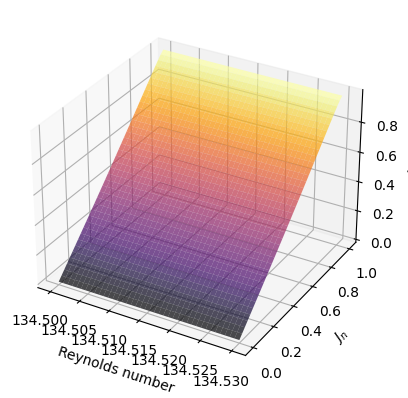

In [56]:
f = plt.figure()
%matplotlib inline
ax = f.add_subplot(111, projection = '3d')
ax.plot_surface(Rs+134.5, Js, Jnp1, alpha = 0.7, cmap = 'inferno', antialiased=True)
ax.set_xlabel('Reynolds number')
ax.set_ylabel('$J_n$')
ax.set_zlabel('$J_{n+1}$')
f.show()

# Predict test trajectories

The test trajectories are initialized near the saddle and can either evolve towards the laminar state or towards the upper state.

In [155]:
n_trajs = 31
initial_time_test = 100
t_test = [mat['aData'][i][0][:, initial_time_test:].flatten() for i in range(n_traj_train, n_trajs)]
x_full_test = [mat['aData'][i][1][:, initial_time_test:]-x_shift for i in range(n_traj_train, n_trajs)]
x_reduced_test = [np.sqrt(mat['xData'][i][1][:, initial_time_test:]) for i in range(n_traj_train, n_trajs)]
parameters_test = [mat['aData'][i][2][0]-134.5 for i in range(n_traj_train, n_trajs)]


In [156]:
%%time
t_rec, x_reduced_rec = advect(ssm.reduced_dynamics.predict, t_test, x_reduced_test, parameters = parameters_test,  dynamics_type='map')


CPU times: user 21.6 s, sys: 263 ms, total: 21.9 s
Wall time: 21.9 s


The prediction of the trajectories is done, let us visualize it as a time series of the reduced coordinate, $\sqrt{I}=J$.

(100.0, 500.0)

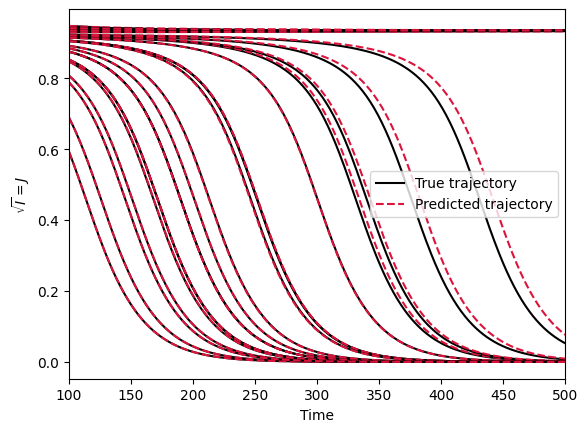

In [157]:
flag = True
for i in range(len(x_reduced_rec)):
    if flag: # add label
        plt.plot(t_test[i], x_reduced_test[i][0,:], '-', c='black', label = 'True trajectory')
        plt.plot(t_rec[i], x_reduced_rec[i][0,:], '--', c='crimson', label = 'Predicted trajectory')
    else:
        plt.plot(t_test[i], x_reduced_test[i][0,:], '-', c='black')
        plt.plot(t_rec[i], x_reduced_rec[i][0,:], '--', c='crimson')
    flag = False
plt.xlabel('Time')
plt.ylabel('$\sqrt{I}=J$')
plt.legend()
plt.xlim(100, 500)

# Use the parametrization to compute the total error

Here we plot the relative error defined as
$$
\frac{|| u(t)_{predicted} - u(t)_{true} ||}{\text{max} || u(t)_{true}||}
$$

WARNING 2023-07-25 22:47:18 legend No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


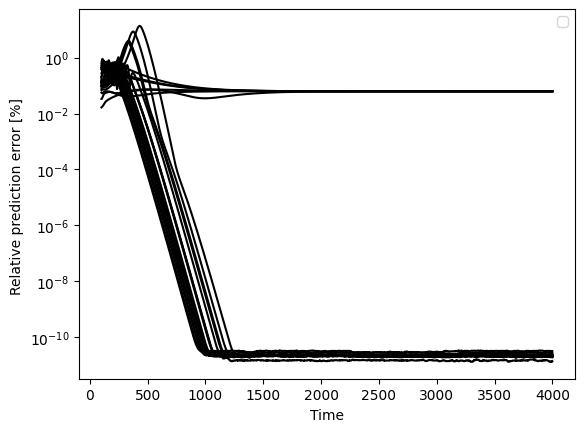

In [158]:
for i in range(len(x_reduced_rec)):
    predicted = ssm.decode(np.concatenate((x_reduced_rec[i], x_reduced_rec[i]*0 + 0.02)))
    error = np.linalg.norm(predicted - x_full_test[i], axis = 0)
    max_norm = np.linalg.norm(x_full_test[i], axis = 0).max()
    
    plt.semilogy(t_test[i], 100 * error/max_norm, '-', c='black')
        #plt.plot(t_rec[i], x_reduced_rec[i][0,:], '--', c='crimson', label = 'Predicted trajectory')

plt.xlabel('Time')
plt.ylabel('Relative prediction error [%] ')
plt.legend()


With the PCA components, we reconstruct the original flow field at  a pre-defined time instant. We show the streamwise component of the velocity field along the center-line of the channel, at $y=0$.

In [179]:
def reconstruct_velocity(vel):
    vel = vel.reshape(-1,1) + x_shift

    fullvector = np.matmul(vel.reshape(1,-1), mat['pcaComponents'])
    return fullvector.reshape([3, 32, 35, 32])

In [181]:
# true velocity:
true_vel = reconstruct_velocity(x_full_test[0][:, 20])
W_true = true_vel[0, :, :, :]
# ssm-reconstructed: 

predicted = ssm.decode(np.concatenate((x_reduced_rec[0], x_reduced_rec[0]*0 + 0.02)))
predicted_vel = reconstruct_velocity(predicted[:, 20])
W_pred = predicted_vel[0, :, :, :]


Text(0.5, 1.0, 'SSM-reconstructed Cross section at $y=0$')

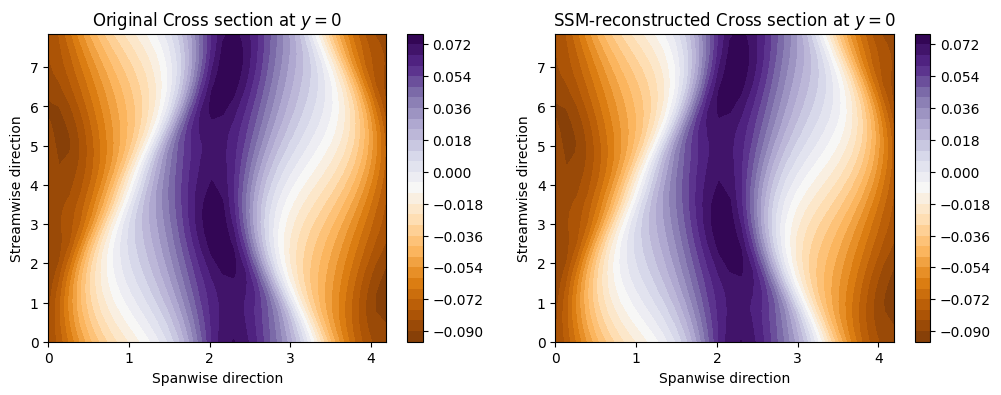

In [188]:
f = plt.figure(figsize = (12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

x_axis = np.linspace(0, 5*np.pi/2, 32)
z_axis = np.linspace(0, 4*np.pi/3, 32)

c1 = ax1.contourf(z_axis, x_axis, W_true[:, 16,:].T, 30, cmap ='PuOr')
ax1.set_xlabel('Spanwise direction')
plt.colorbar(c1)

ax1.set_ylabel('Streamwise direction')
ax1.set_title('Original Cross section at $y=0$')


c2 = ax2.contourf(z_axis, x_axis, W_pred[:, 16,:].T, 30, cmap ='PuOr')
plt.colorbar(c2)
ax2.set_xlabel('Spanwise direction')

ax2.set_ylabel('Streamwise direction')
ax2.set_title('SSM-reconstructed Cross section at $y=0$')

